### Load in necessary libraries

In [1]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Data_Process/scripts/")

In [41]:
from util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import all data 

In [4]:
DIRPATH = f"{home}/Documents/projects/CarPriceRegression/carPrice/"
EXT = ".csv"

In [5]:
data = readData(DIRPATH,EXT)

In [6]:
data.shape

(99187, 9)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99187 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   mileage       99187 non-null  int64  
 5   fuelType      99187 non-null  object 
 6   tax           99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engineSize    99187 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 7.6+ MB


In [8]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


### Observations:

* There are zero null values
* model and transmission are object type and the rest are numeric type 
* year, tax, and engineSize require some feature transformation

### Remove tax column since tax is a product of price. The more price you pay for a car, the more sales tax you pay. It is almost an after effect of a price. It is also not a vital decision on how much people are willing to pay for a car since tax is very standard across all cars. 

In [9]:
data.drop("tax",axis=1,inplace=True)

### Garbage Collect

In [10]:
gc.collect()
%reset -f out

Flushing output cache (2 entries)


-----

### Look at relationship among features

### Year

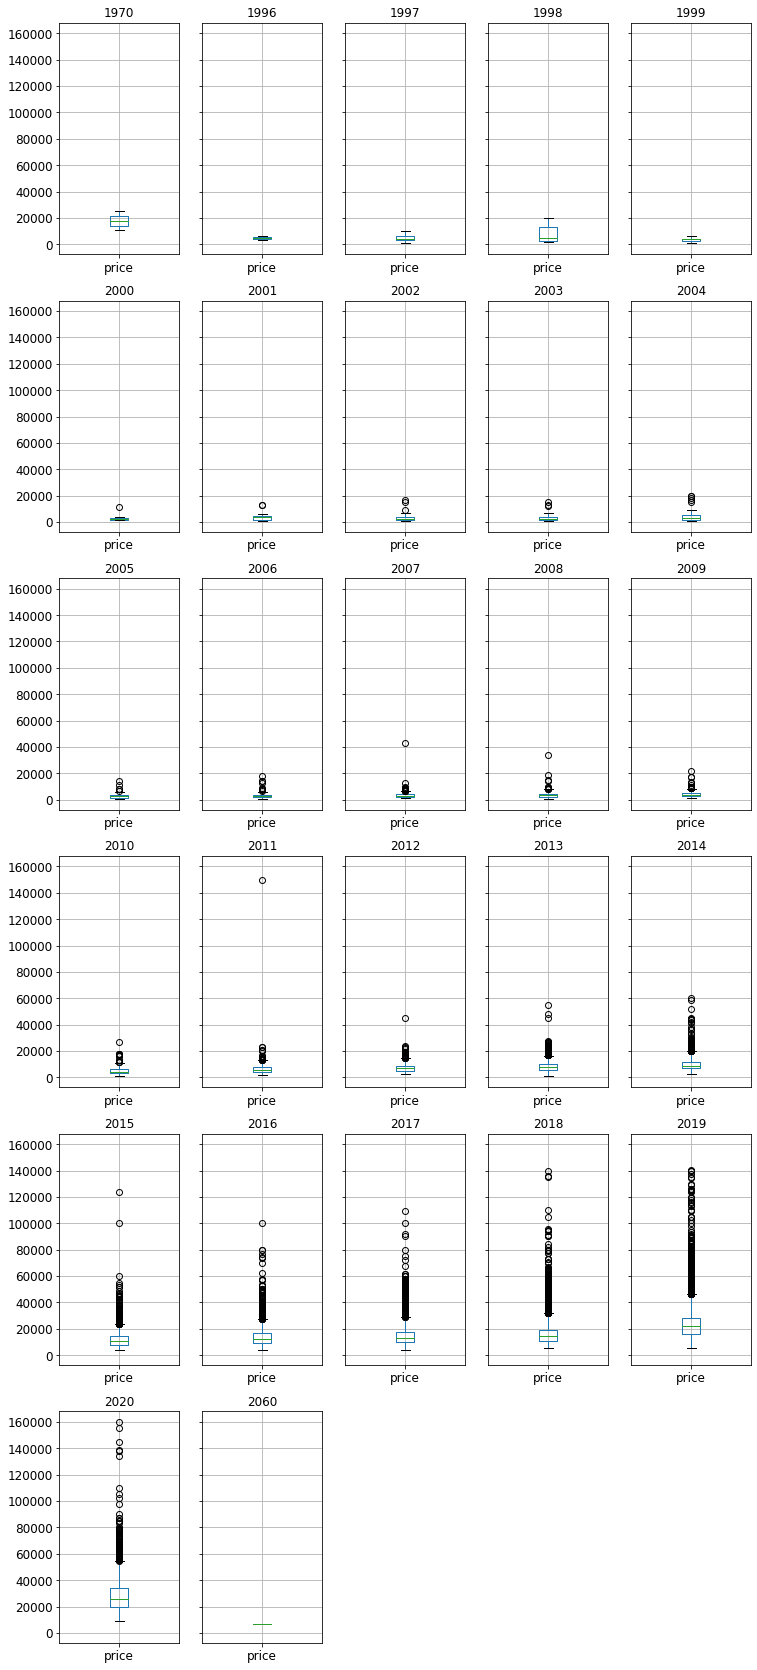

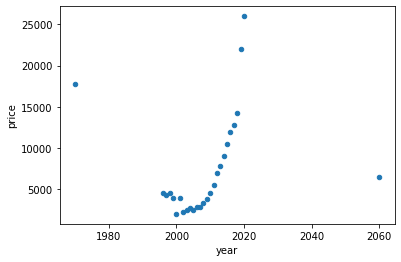

,year,price
26,2060,1
0,1970,2
1,1996,2
2,1997,4
4,1999,6
3,1998,8
5,2000,9
6,2001,20
7,2002,31
8,2003,34


In [11]:
EDA_CAT_func("year","price",data,12,(12,30),(6,5))

### observations:
   * remove entries that are in 2060, probably a typo
   * combine years into "0" (O), "2"(>10year old), "3"(>5 year old),"4" (<=2 yr old), "5"(<1 yrold)
   * overall price increases with year which made sense 
   * There are a lot of outliers as well. 
   * probably good idea to turn this feature into a categorical feature

In [12]:
# remove 2060 
data_trimmed = data[(data.year<2060)]
# bin the years before 
bins = {(1970,2000):"0",(2001,2010):"1",
        (2011,2015):"2",(2016,2018):"3",
        (2019,2020):"4"}

In [13]:
data_trimmed["binned_year"]=data_trimmed.year.apply(lambda x:
                                                   binning_func(x,bins))

# remove year col

data_trimmed.drop("year",axis=1,inplace=True)

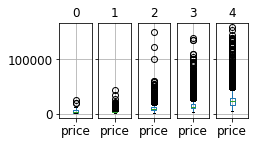

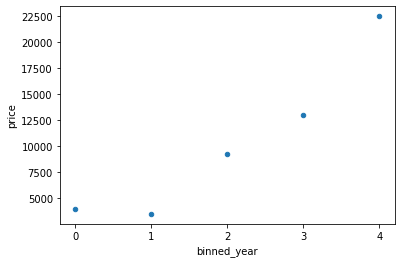

,binned_year,price
0,0,31
1,1,1273
2,2,15399
4,4,31236
3,3,51247


In [14]:
EDA_CAT_func("binned_year", "price", data_trimmed, 12,(6,6),(3,9))

### Now you see more of a clear indication of trend. 

### mileage

* Look at scatter plot relationship

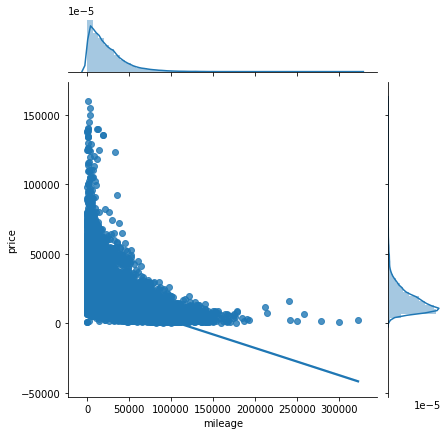

In [15]:
sns.jointplot(data=data_trimmed,
             x="mileage",
             y="price",
             kind="reg")
plt.show()

### It might better to turn milage into categorical features to get a better relationship

### We will bin the features into 6 categories:
  * 0: <= 3000
  * 1: <= 10000 
  * 2: <= 30000
  * 3: <= 60000
  * 4: <= 100000
  * 5: > 100000

In [16]:
mil_thresholds = {(0,3000):"0",
             (3001,10000):"1",
             (10001,30000):"2",
             (30001,60000):"3",
             (60001,100000):"4",
             (100001,350000):"5"}

In [17]:
data_trimmed["mil_cat"] = data_trimmed.mileage.apply(lambda x: binning_func(x, mil_thresholds))
# remove old milage column
data_trimmed.drop("mileage",axis=1,inplace=True)

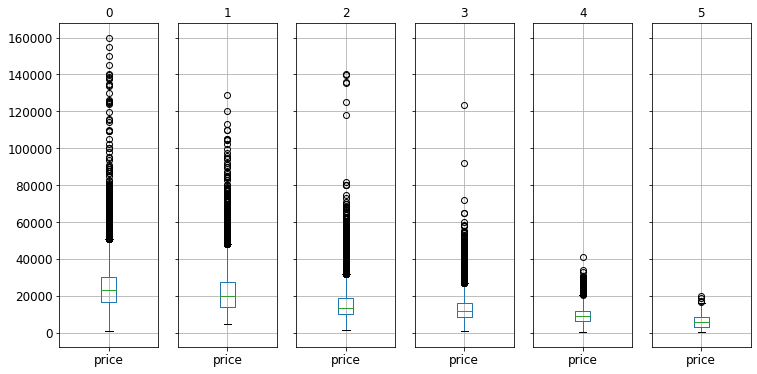

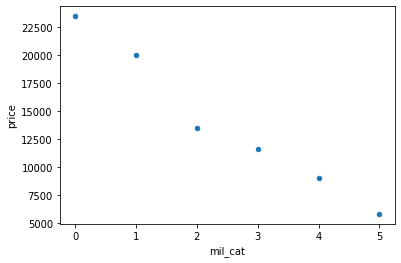

,mil_cat,price
5,5,804
4,4,5319
0,0,11218
1,1,20530
3,3,22014
2,2,39301


In [18]:
EDA_CAT_func("mil_cat","price",data_trimmed,12,(12,6),(1,6))

### Much better and see a clear indication of price drop as mileage goes down

### mpg

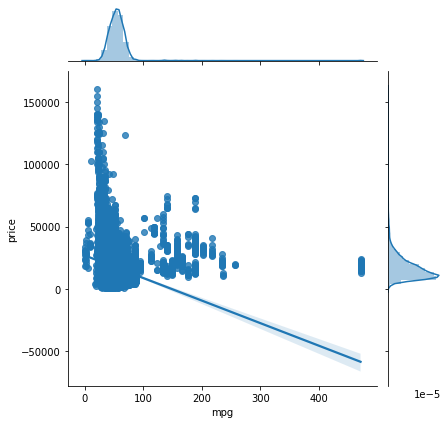

In [19]:
sns.jointplot(data=data_trimmed,
             x="mpg",
             y="price",
             kind="reg")
plt.show()

### Not a clear relationship, let's try to bin again to group into high low gas milage

In [20]:
data_trimmed.mpg.describe()

count    99186.000000
mean        55.166950
std         16.138556
min          0.300000
25%         47.100000
50%         54.300000
75%         62.800000
max        470.800000
Name: mpg, dtype: float64

In [21]:
bin_mpg = {(0,16):"0",
            (17,40):"1",
            (41,50):"2",
             (51,62):"3",
             (63,475):"4"}

In [22]:
data_trimmed["binned_mpg"]=data_trimmed.mpg.apply(lambda x:
                                                 binning_func(x,bin_mpg))
# drop mpg column
data_trimmed.drop("mpg",axis=1,inplace=True)

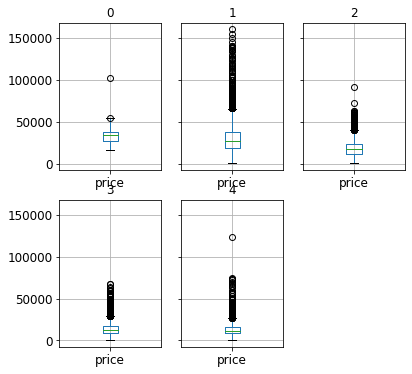

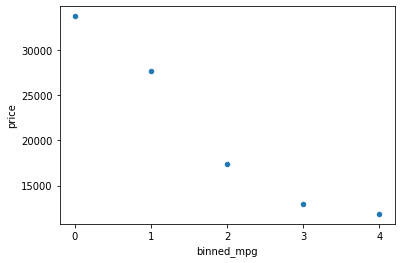

,binned_mpg,price
0,0,35
1,1,11022
2,2,22059
4,4,22765
3,3,36212


In [23]:
EDA_CAT_func("binned_mpg","price",data_trimmed,12,(6,6),(2,3))

### It makes sense that low gas milage implies more exotic car so less efficient fuel. 

### Engine Size

In [24]:
data_trimmed.engineSize.unique()

array([2. , 1.8, 1.2, 1.6, 1.4, 2.5, 2.2, 1.5, 1. , 1.3, 0. , 2.4, 3. ,
       2.8, 4.2, 4.5, 3.2, 1.9, 2.1, 5.5, 4. , 6.2, 3.5, 2.9, 4.7, 2.3,
       6. , 5. , 2.7, 3.7, 5.4, 4.3, 1.7, 1.1, 0.6, 4.4, 6.6, 5.2, 4.1,
       6.3])

### There are 40 engineSize, let's look at them as cateogrical value

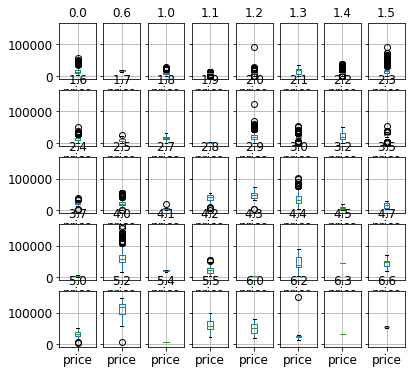

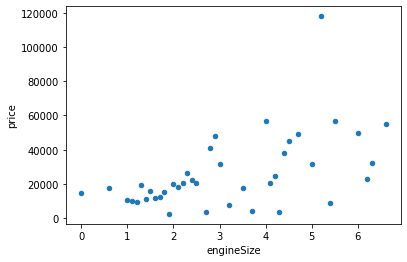

,engineSize,price
28,4.3,1
38,6.3,1
34,5.4,1
30,4.5,1
24,3.7,2
26,4.1,2
39,6.6,2
36,6.0,2
1,0.6,7
18,2.7,8


In [25]:
EDA_CAT_func("engineSize","price",data_trimmed,12,(6,6),(5,8))

### Will definitely benefit from grouping into categories of engineSize

In [26]:
sorted(data_trimmed.engineSize.unique())

[0.0,
 0.6,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.7,
 2.8,
 2.9,
 3.0,
 3.2,
 3.5,
 3.7,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.7,
 5.0,
 5.2,
 5.4,
 5.5,
 6.0,
 6.2,
 6.3,
 6.6]

In [27]:
bin_engine = {(0.0,2.0):"0",
              (2.1,4.0):"1",
              (4.1,5.0):"2",
              (5.1,6.8):"4"}

In [28]:
data_trimmed["engine_binned"] = data_trimmed.engineSize.apply(lambda x:
                                                             binning_func(x,bin_engine))
# remove engine
data_trimmed.drop("engineSize",axis=1,inplace=True)

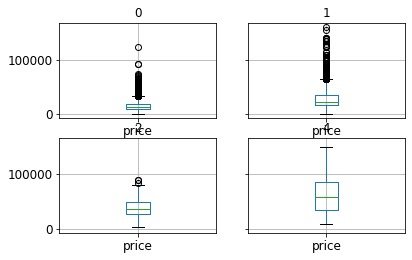

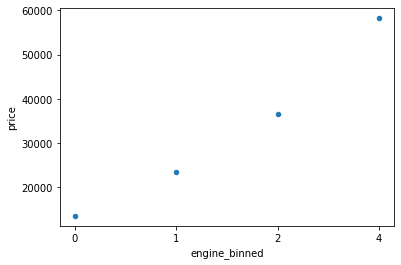

,engine_binned,price
3,4,86
2,2,185
1,1,11241
0,0,87674


In [29]:
EDA_CAT_func("engine_binned","price",data_trimmed,12,(6,6),(3,2))

### Much better. You see a clear trend as the engine goes up, it costs more. 

### Look at object type cols: transmission, fuelType, model

In [30]:
data_trimmed.transmission.unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

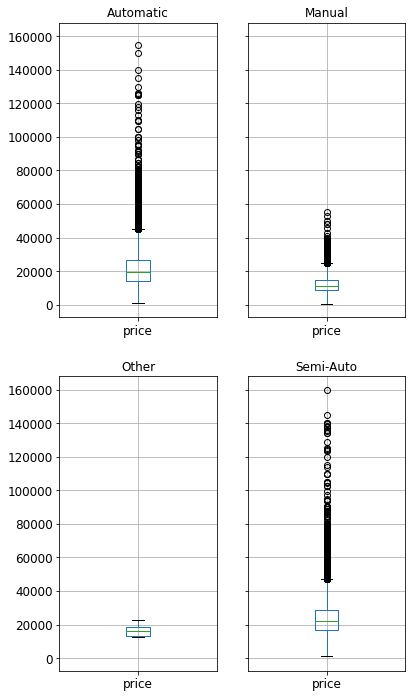

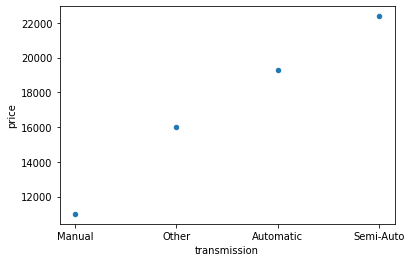

,transmission,price
2,Other,9
0,Automatic,20055
3,Semi-Auto,22677
1,Manual,56445


In [35]:
EDA_CAT_func("transmission","price",data_trimmed,12,(6,12),(2,2))

### It appears that manual is the cheapest and semi-auto is the most expensive

In [36]:
data_trimmed.fuelType.unique()

array(['Petrol', 'Other', 'Hybrid', 'Diesel', 'Electric'], dtype=object)

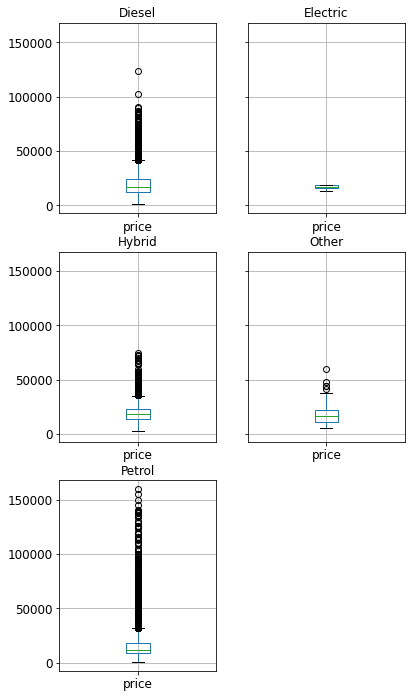

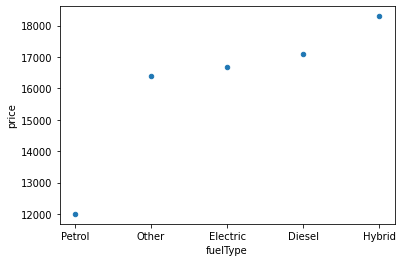

,fuelType,price
1,Electric,6
3,Other,247
2,Hybrid,3078
0,Diesel,40928
4,Petrol,54927


In [38]:
EDA_CAT_func("fuelType","price",data_trimmed,12,(6,12),(3,2))

### petrol tends to be least expensive and hybrid is the most.  But definitely see a correlation. 

In [40]:
data_trimmed.model.nunique()

195

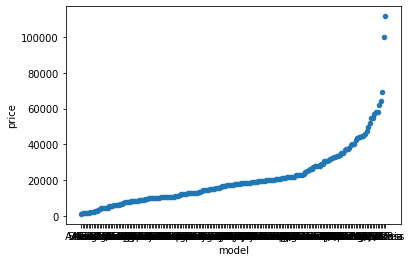

,model,price
194,230,1
17,Accent,1
58,Escort,1
163,Transit Tourneo,1
10,A2,1
193,220,1
21,Amica,1
130,RS7,1
131,Ranger,1
191,180,1


In [46]:
EDA_CAT_func("model","price",data_trimmed,12,(6,12),(100,100))[:50]

### There are a lot of car models but you do see a trend in the car price. 

### Let's join price and count to see if we need to merge or get rid of some models

In [56]:
price_table = data_trimmed.groupby("model").price.median().reset_index()
count_table = data_trimmed.groupby("model").price.count().reset_index()
price_count_table = pd.merge(count_table,price_table,on="model",suffixes=("_count","_price"))

In [58]:
price_count_table.sort_values("price_count")[:50]

,model,price_count,price_price
194,230,1,4500.0
17,Accent,1,1295.0
58,Escort,1,3000.0
163,Transit Tourneo,1,12450.0
10,A2,1,2490.0
193,220,1,19995.0
21,Amica,1,1750.0
130,RS7,1,33490.0
131,Ranger,1,14495.0
191,180,1,10799.0


In [59]:
price_count_table.sort_values("price_count")[-50:]

,model,price_count,price_price
93,Ka+,531,8300.0
83,I30,536,10186.0
34,C-MAX,543,10000.0
177,X3,551,29357.0
79,Grandland X,568,16828.0
29,B Class,591,20900.0
187,Zafira,599,10698.0
53,Crossland X,683,12798.0
26,Auris,712,12711.5
153,T-Roc,733,21990.0


### It might be important to group the low count cars into one group and add car brand info as well.